In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64,num_workers=2, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: 0.0
 - max: 1.0
 - mean: 0.13066047740240005
 - std: 0.3081078089011192
 - var: 0.0949304219058486


In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, 10)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.log_softmax(h)
        return out

model = Model()
model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
model.train()

losses = []
for epoch in range(15):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.data[0])
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data[0]), 
                end='')
            
    print()

 Train Epoch: 0 [57664/60000 (96%)]	Loss: 0.261604
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 0.068739
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 0.136685
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 0.102887
 Train Epoch: 4 [57664/60000 (96%)]	Loss: 0.026075
 Train Epoch: 5 [57664/60000 (96%)]	Loss: 0.236429
 Train Epoch: 6 [57664/60000 (96%)]	Loss: 0.111673
 Train Epoch: 7 [57664/60000 (96%)]	Loss: 0.093342
 Train Epoch: 8 [57664/60000 (96%)]	Loss: 0.062590
 Train Epoch: 9 [57664/60000 (96%)]	Loss: 0.056465
 Train Epoch: 10 [57664/60000 (96%)]	Loss: 0.010314
 Train Epoch: 11 [57664/60000 (96%)]	Loss: 0.046037
 Train Epoch: 12 [57664/60000 (96%)]	Loss: 0.122784
 Train Epoch: 13 [57664/60000 (96%)]	Loss: 0.051168
 Train Epoch: 14 [57664/60000 (96%)]	Loss: 0.041020


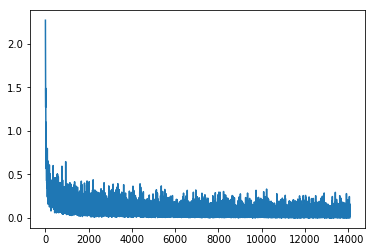

In [6]:
plot(losses)

In [8]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

Accuracy: 0.9748
